In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_subject_levels

In [2]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')

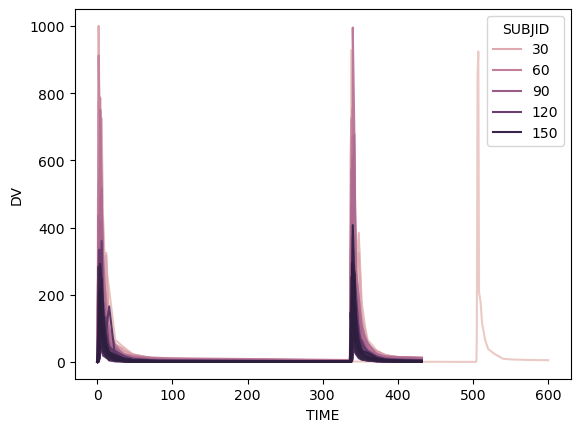

In [3]:
plot_subject_levels(df)

In [4]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
from utils import one_compartment_model, objective_function

In [5]:
#prepare day 1 data
opt_df = df.dropna(subset = 'DV').copy()
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

#Within day 1 data, per subject identify the max concentration
#Drop time points occuring before the max, and set the time at that max conc to t=0
dfs = []
for c in opt_df['SUBJID'].drop_duplicates():
    work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
    max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
    work_df = work_df.iloc[max_idx:, :]
    work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
    dfs.append(work_df.copy())
work_df = pd.concat(dfs)

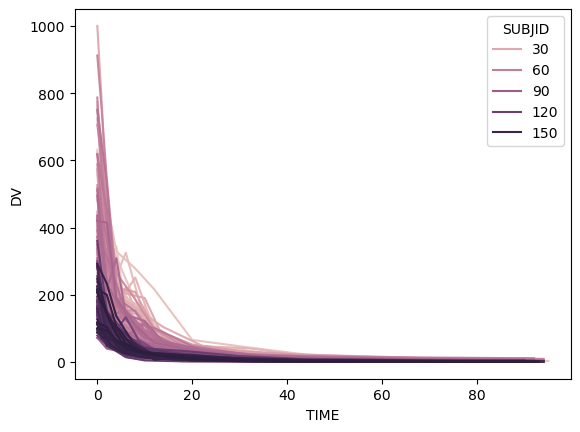

In [6]:
#plot the prepared data
plot_subject_levels(work_df)

In [7]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial
from utils import optimize_with_checkpoint_joblib

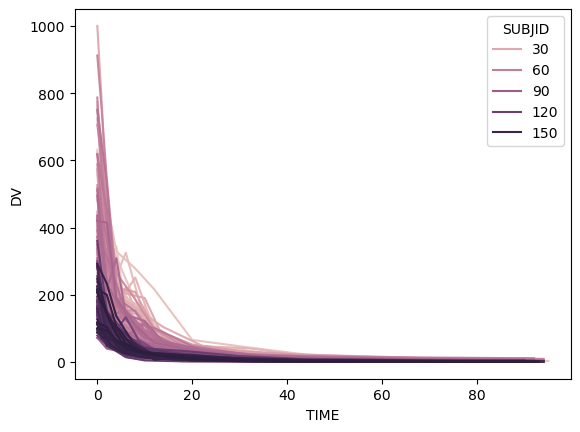

In [8]:
from sklearn.preprocessing import RobustScaler
scale_df = work_df.copy()
#scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
mgkg_scaler = RobustScaler()
age_scaler = RobustScaler()

scale_df['MGKG'] = (scale_df['DOSR'] / scale_df['WT'])
scale_df['MGKG_scale'] = mgkg_scaler.fit_transform(scale_df[['MGKG']])
scale_df['AGE_scale'] = age_scaler.fit_transform(scale_df[['AGE']])
scale_df['DOSR'] = scale_df['DOSR'] / 100
plot_subject_levels(scale_df)

# Just Optimizing the ODE

In [19]:
from scipy.optimize import minimize


# opt_df = opt_df.loc[opt_df['TIME'] >= 1, :].copy()
initial_guess = [0.6, 2.0]  # Initial guesses for k and Vd
result_0 = optimize_with_checkpoint_joblib(objective_function, initial_guess, n_checkpoint=5, checkpoint_filename='check.jb', args=(
    # Bounds added to prevent negative values
    scale_df,), bounds=[(1e-6, None), (1e-6, None)])
# result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

No checkpoint found, starting from initial guess.


100%|██████████| 159/159 [00:00<00:00, 285.42it/s]


1
no log


100%|██████████| 159/159 [00:00<00:00, 301.10it/s]


2
no log


100%|██████████| 159/159 [00:00<00:00, 302.73it/s]


3
no log


100%|██████████| 159/159 [00:00<00:00, 259.97it/s]


4
no log


100%|██████████| 159/159 [00:00<00:00, 246.87it/s]


5
Iteration 5: Checkpoint saved to check_5.jb
no log


100%|██████████| 159/159 [00:00<00:00, 303.85it/s]


6
no log


100%|██████████| 159/159 [00:00<00:00, 272.32it/s]


7
no log


100%|██████████| 159/159 [00:00<00:00, 272.36it/s]


8
no log


100%|██████████| 159/159 [00:00<00:00, 292.55it/s]

9
no log


In [20]:
result_0

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1856467.5537046732
        x: [ 6.479e-01  2.799e+00]
      nit: 9
      jac: [ 1.197e+06  9.741e+05]
     nfev: 201
     njev: 67
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

# With Covariates

In [34]:
from utils import objective_function__mgkg_age
objective_func = partial(objective_function__mgkg_age, mgkg_c = 'MGKG_scale', age_c = 'AGE_scale')


In [35]:
#scale_df = scale_df.reset_index()
initial_guess = [np.log(0.6), np.log(2.0), 0, 0, 0, 0]  # Initial guesses for k_pop and Vd_pop, k_beta_age, k_beta_mgkg, Vd_beta_age, Vd_beta_mgkg
result = optimize_with_checkpoint_joblib(objective_func, initial_guess, n_checkpoint=5, checkpoint_filename='check_args.jb', args=(
    # Bounds added to prevent negative values
    scale_df,), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None)])
# result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

No checkpoint found, starting from initial guess.
1
no log
2
no log
3
no log


In [38]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1852215.317278151
        x: [-6.263e-01  7.941e-01 -2.039e-02 -4.554e-02  1.532e-02
             4.605e-02]
      nit: 3
      jac: [ 3.542e+05 -6.272e+05  4.265e+05 -3.805e+04 -3.063e+05
             1.348e+05]
     nfev: 105
     njev: 15
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [39]:
np.exp(result['x'])

array([0.53459137, 2.21245584, 0.97981525, 0.95548526, 1.01544022,
       1.04712277])

In [14]:
def generate_predictions__mgkg_age(optimized_result, 
                                   df, subject_id_c='SUBJID', dose_c='DOSR',
                                   time_c='TIME', conc_at_time_c='DV',
                                   mgkg_c='MGKG', age_c='AGE'):
    predictions = {}
    k_pop, Vd_pop, k_beta_age, k_beta_mgkg, Vd_beta_age, Vd_beta_mgkg = optimized_result.x
    data = df.copy()
    for subject in data[subject_id_c].unique(): # Loop through each subject in the dataset
        subject_filt =  data[subject_id_c] == subject
        subject_data = data.loc[subject_filt, :].copy()
        
        mgkg = subject_data[mgkg_c].values[0]  # Extract dose information for the subject
        age = subject_data[age_c].values[0]
          # Get data for the current subject
        initial_conc = subject_data[conc_at_time_c].values[0]  # Get the initial concentration
        with np.errstate(over='ignore'):
            k_i = np.exp(k_pop + (k_beta_age * age) + (k_beta_mgkg * mgkg))
            Vd_i = np.exp(Vd_pop + (Vd_beta_age * age) + (Vd_beta_mgkg * mgkg))
        # Solve the differential equation for the current subject
        sol = solve_ivp(one_compartment_model, [subject_data[time_c].min(), subject_data[time_c].max()], [initial_conc], 
                        t_eval=subject_data[time_c], args=(k_i, Vd_i, mgkg))
        predictions[subject] = sol
    return predictions

In [22]:
from utils import generate_ivp_predictions, stack_ivp_predictions, merge_ivp_predictions
preds = generate_predictions__mgkg_age(result, scale_df)
preds_plot_df = merge_ivp_predictions(scale_df, preds)

In [25]:
from utils import generate_ivp_predictions, stack_ivp_predictions, merge_ivp_predictions
predictions = generate_ivp_predictions(result_0, scale_df)

In [26]:
merge_df_0 = merge_ivp_predictions(preds_plot_df, predictions)
merge_df_0.head()
merge_df = merge_df_0.copy()

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,MGKG,MGKG_scale,AGE_scale,Pred_DV_x,Pred_DV_y
0,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,3.571429,0.24895,0.071429,275.000000,275.000000
1,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,3.571429,0.24895,0.071429,217.343273,218.174779
2,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,3.571429,0.24895,0.071429,171.749262,173.067000
3,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,3.571429,0.24895,0.071429,135.672550,137.236706
4,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,3.571429,0.24895,0.071429,84.842891,86.473880


In [23]:
merge_df['PRED_DV_diff'] = (merge_df['Pred_DV'] - merge_df['DV'])
merge_df['PRED_DV_diff_sign'] = np.sign(merge_df['PRED_DV_diff']+1e-6)
merge_df['PRED_DV_diff_log'] = np.log((np.abs(merge_df['PRED_DV_diff']) + 1e-6)) * merge_df['PRED_DV_diff_sign']  
merge_df['PRED_DV_diff_%'] = 100 * ((merge_df['Pred_DV'] - merge_df['DV'])/ ((merge_df['Pred_DV'] + merge_df['DV']) / 2))
merge_df['log_PRED_DV_diff_%'] = np.log(np.abs(merge_df['PRED_DV_diff_%']) + 1e-6)

In [24]:
merge_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,Pred_DV,PRED_DV_diff_%,log_PRED_DV_diff_%,PRED_DV_diff,PRED_DV_diff_sign,PRED_DV_diff_log
0,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,2.750000e+02,0.0,-13.815511,0.0,1.0,-13.815511
1,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,2.181748e+02,-11.175521,2.413726,-25.825221,-1.0,-3.251352
2,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,1.730670e+02,13.618789,2.61145,22.067,1.0,3.094083
3,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,1.372367e+02,5.415952,1.689349,7.236706,1.0,1.979166
4,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,8.647388e+01,-51.848301,3.948322,-60.52612,-1.0,-4.103075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,159.0,1.0,1.0,21.0,24.0,1.0,NaN,7.91,1.0,B,1.0,33.0,95.0,1.606845e+00,-132.463116,4.886304,-6.303155,-1.0,-1.84105
1616,159.0,1.0,1.0,33.0,36.0,1.0,NaN,3.02,1.0,B,1.0,33.0,95.0,1.000361e-01,-187.175006,5.232044,-2.919964,-1.0,-1.071572
1617,159.0,1.0,1.0,45.0,48.0,1.0,NaN,1.7,1.0,B,1.0,33.0,95.0,6.228258e-03,-198.539877,5.29099,-1.693772,-1.0,-0.526958
1618,159.0,1.0,1.0,69.0,72.0,1.0,NaN,1.42,1.0,B,1.0,33.0,95.0,2.433310e-05,-199.993146,5.298283,-1.419976,-1.0,-0.35064


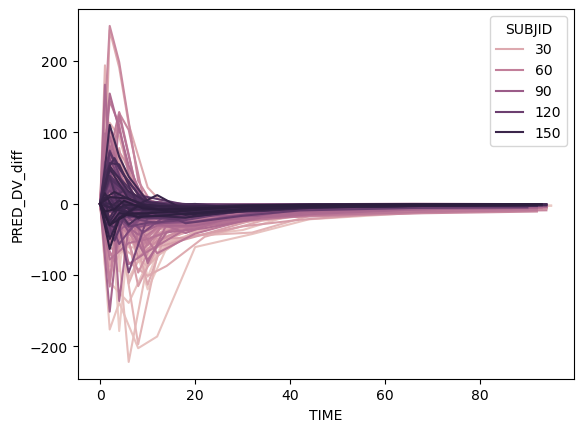

In [25]:
plot_subject_levels(merge_df, x = 'TIME', y = 'PRED_DV_diff')

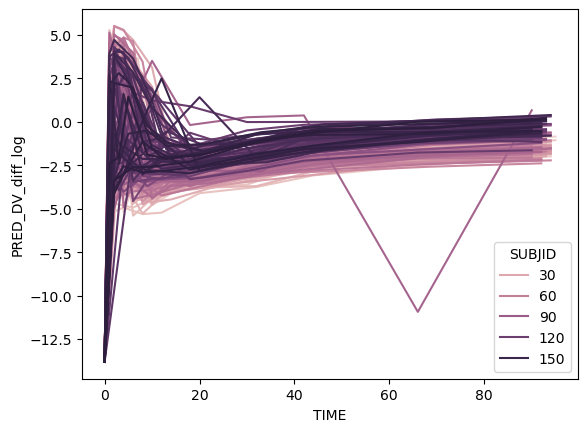

In [26]:
plot_subject_levels(merge_df, x = 'TIME', y = 'PRED_DV_diff_log')

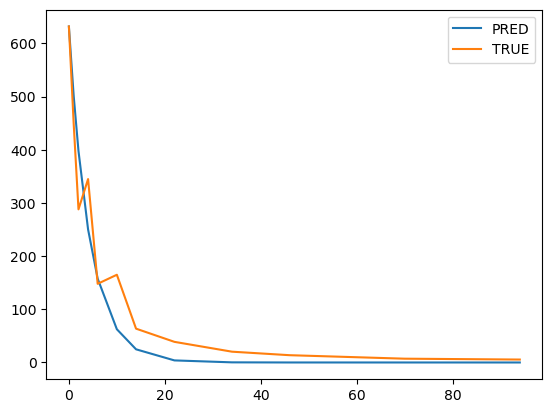

In [27]:
import matplotlib.pyplot as plt
subject_id = 5
plot_df = scale_df.loc[scale_df['SUBJID'] == subject_id, :]
plt.plot(predictions[subject_id].t, predictions[subject_id].y[0], label = 'PRED')
plt.plot(predictions[subject_id].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()

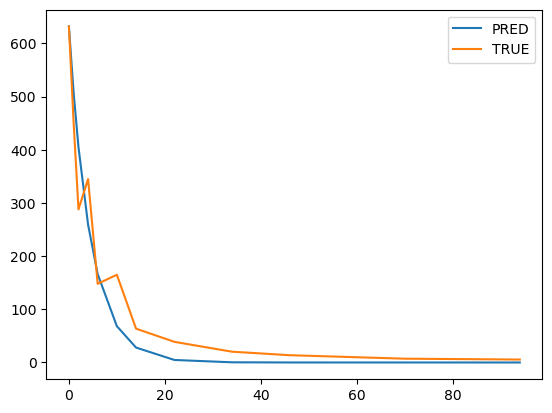

In [24]:
import matplotlib.pyplot as plt
subject_id = 5
plot_df = preds_plot_df.loc[preds_plot_df['SUBJID'] == subject_id, :]
plt.plot(preds[subject_id].t, preds[subject_id].y[0], label = 'PRED')
plt.plot(preds[subject_id].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()